# Example: Binomial Lattice Models of Equity Share Price

## Background
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.png" width="280"/>
    </center>
</div>

Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in the . Thus, we’ll take an approach similar to the short-rate calculations discussed previously. 

## Learning Objectives
The objective of this example is to familiarize students with the application of simple probability mass functions to predict future uncertain quantities such as commodity prices, equity share prices, interest rates, etc. In particular, in this example, we will:

* __Objective 1__: Estimate typical values for the tuple $(u,d,p)$ using historical data for different the share price of different firms.  
* __Objective 2__: Compare bionomial lattice model simulations of share price versus historical data 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality.

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the lattice model simulation of equity share prices:

The `MyBinomialEquityPriceTree` encodes the lattice model. The `MyBinomialEquityPriceTree` has several essential fields:
    
* The `connectivity::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds the indexes of the children for each parent node of the tree.
* The `levels::Union{Nothing, Dict{Int64,Array{Int64,1}}}` field holds indexes of nodes that belong to each level of the tree, i.e., a particular trading day.
* The `u::Float64` field holds the value of the `up` factor
* The `d::Float64` field holds the value of the `down` factor
* The `p::Float64` field holds the value of the probability of an `up` move.
* The `data::Union{Nothing, Dict{Int64, MyBiomialLatticeEquityNodeModel}}` holds each node in the tree; nodes are of type `MyBiomialLatticeEquityNodeModel`


Each node in the tree is a `MyBiomialLatticeEquityNodeModel` type. The `MyBiomialLatticeEquityNodeModel` has two important fields:
* The `price::Float64` field holds the price value for a node
* The `probability::Float64` field holds the probability value associated with this node

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function loaddatafile(; firm::Int = 1, year::String = "Year-1") -> DataFrame` 
 > This function, which load hostorical share price data, takes an [Int](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers) that encodes a `firm index` and a [String](https://docs.julialang.org/en/v1/manual/strings/) arguement that holds the `year` parameter of the dataset. The historical share price data is returned to the caller as a [DataFrame](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`.
 
`function analyze(R::Array{Float64,1};  Δt::Float64 = (1.0/365.0)) -> Tuple{Float64,Float64,Float64}`
> The `analyze(...)` function takes an array of return values in the `R` argument and a value of the time-step size of the simulation in the $\Delta{t}$ parameter (default value of 1-day) and returns estimated values for the lattice model parameters $(u,d,p)$.  
 
`function build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple) -> MyBinomialEquityPriceTree` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(u,d,p)$ values) and returns an instance of the `MyBinomialEquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). Note: the `MyBinomialEquityPriceTree` returned from the `build(...)` function does not have price or probability information computed yet. To populate this data, call the `populate(...)` function.

`function populate(model::MyBinomialEquityPriceTree, Sₒ::Float64, h::Int) -> MyBinomialEquityPriceTree`
> The `populate(...)` function takes the `model::MyBinomialEquityPriceTree` instance returned from `build(...)`, a starting share price $S_{o}$ and the height of the tree, i.e., the number of time steps to simulate, and returns an updated `model::MyBinomialEquityPriceTree` instance with the price and probabilities computed for each node in the tree.

`function generate_firm_index_set() -> Set{Int64}`
> The `generate_firm_index_set()` function generates the set of `firm_id` values for which we have data files for all the years of this study, i.e., `Year-1,...,Year-5`. 

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`


## Prerequisite: Test the lattice model, and load the historical data set
Let’s start by calculating the hypothetical share price from an example (reproduced from Chapter 13 of Hull) before diving into historical data analysis. The lattice in this example has three levels (`L=0,1,2`), with an initial share price of $S_{\circ}=20.0$ USD. An `up` move has a probability of `p = 0.6523` and a magnitude of `u = 1.1`, while a `down` move has a magnitude of  `d = 0.9`.

### Implementation
Calculating the future share price with a binomial lattice requires setting the model’s parameters, including the initial share price (as a `Float64`), the number of time steps to simulate into the future, which equals the number levels of the tree starting from zero (as an `Int64`), the up and down move magnitudes (as `Float64` values), and the probability of an up move (as a `Float64`):

In [2]:
Sₒ,T,u,d,p = 20.0,2,1.1,0.9,0.6523;

Once these values are set, we use the `build(…)` function to create an empty lattice model of type `MyBinomialEquityPriceTree`, which is then passed to the `populate(…)` function using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>`. The `populate(…)` function calculates the prices and probabilities of each node (type `MyBiomialLatticeEquityNodeModel`) in the tree:

In [3]:
test_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ, T));

Finally, we compare the price values we calculated to those reported by Hull using the [PrettyTables.jl](https://github.com/ronisbr/PrettyTables.jl) package. We populate the `hull_price_dictionary` dictionary with the price values at each node, and compare those to our values. We populate the `prereq_data_table` array using a `for` loop, then use the `pretty_table(...)` function to display the table:

In [4]:
number_of_nodes = length(test_model.data);
prereq_data_table = Array{Any,2}(undef,number_of_nodes,3)
prereq_header_table = (["Index","Hull","This study"], ["","USD/share", "USD/share"]);
hull_price_dictionary = Dict(0=>20.0, 1=>22.0,2=>18.0,3=>24.2,4=>19.8,5=>16.2);
for i ∈ 0:(number_of_nodes-1)
    prereq_data_table[i+1,1] = i
    prereq_data_table[i+1,2] = hull_price_dictionary[i]
    prereq_data_table[i+1,3] = test_model.data[i].price
end

pretty_table(prereq_data_table,header=prereq_header_table, tf=tf = tf_html_default)

Index,Hull,This study
,USD/share,USD/share
0,20.0,20.0
1,22.0,22.0
2,18.0,18.0
3,24.2,24.2
4,19.8,19.8
5,16.2,16.2


Finally, we'll set some constant values that are used throughtout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value) and the specify the number of trading days to simulate in the `T` variable:

In [5]:
Δt = (1.0/252.0);
T = 21;

### Load the historical dataset
Load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [6]:
dataset = Dict{Int64,DataFrame}();
set_of_firms = generate_firm_index_set();

years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
while (isempty(set_of_firms) == false)
    firm_index = pop!(set_of_firms)
    
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end 

Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!)

We combine all the annual firm specific `DataFrame` instances stored in the `dataset`dictionary into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `df` variable:

In [7]:
max_number_of_records = 1256
number_of_firms = length(dataset)
for (firm_index, data) ∈ dataset
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

Let's select a random firm with `firm_index` to explore in this study by calling the `rand` function of the keys of the `dataset` dictionary, and then pull the histiorical data out of `dataset` that associated with this firm and store it in the variable `firm_data`:

In [8]:
firm_index = keys(dataset) |> collect |> rand;
firm_index = 172
firm_data = dataset[firm_index]

println("The (randomly) selected firm in this study: $(firm_index)")

The (randomly) selected firm in this study: 172


## Objective 1: Estimate the up, down and probability of an up move from data
After validating our lattice implementation, it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we need to model or estimate three critical parameters: $p$, $u$, and $d$.

* The $p$ parameter represents the probability of a share price increase or an `up` move between two periods $j\rightarrow{j+1}$. As a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
* The $u$ parameter represents the amount of an `up` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move will give $S_{j+1} = u\cdot{S}_{j}$.
* The $d$ parameter represents the amount of a `down` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move will give $S_{j+1} = d\cdot{S}_{j}$.

To estimate the $(u,d,p)$ parameters, let's utilize the `loaddatafile(...)` function to load historical (deidentified) daily price datasets for firms that comprise the S&P 500, which we've labeled as `Firm-1,...` for five consective years `Year-1` through `Year-5`. 

### Estimate the `u`, `d` and probability `p` parameters from data
Now that we have loaded the data, we can calculate the number of `up` and `down` moves, and the magnitude of these moves occuring in the dataset. To do this, we assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the time period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, subsequently, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/365$, i.e., the fraction of a year that occurs in a single day.

#### Implementation
After specifying a value for $\Delta{t}$, we set the `number_of_trading_days` variable by calling the `nrow(..)` function on the combined dataset `df`, and initialize an array that holds the values for $\mu_{j,j-1}$, named `return_array`. We then populate the `return_array` using a `for` loop; during each pass through the loop, we get values for $S_{j-1}$ and $S_{j}$, i.e., the VWAP for the two days from the dataset `df`, and then we compute (and store) the annualized value of $\mu_{j,j-1}$ parameter in the `return_array`:

In [9]:
return_array = Array{Float64,1}(undef, max_number_of_records - 1)
for j ∈ 2:max_number_of_records
    
    S₁ = firm_data[j-1,:volume_weighted_average_price];
    S₂ = firm_data[j,:volume_weighted_average_price];
    return_array[j-1] = (1/Δt)*log(S₂/S₁);
end

Using the `return_array`, we compute the expected magnitide of an `up` move `ū`, the expected magnitide of a `down` move `d̄` , and the estimated probability `p̄` of an `up` move by calling the `analyze(...)` function:

In [10]:
(ū,d̄,p̄) = analyze(return_array, Δt = Δt);

### Build binomial lattice model using historial $(u,d,p)$ parameters
Let's construct an instance of the `MyBinomialEquityPriceTree` type using the estimated values for `(u,d,p)`. This enables us to calculate the prices and probabilities in the tree. Westore the populated model in the variable `model` for future use.

Firstly, we need to set a value for the `T` variable, specifying the number of future days to simulate. Time steps are represented in the tree as levels `L = 0,1,..., T`, where each level represents $\Delta{t}$ units of time, which is a trading day. We then specify the `start_index` as the trading day index in the combined dataset `df`, which will serve as the tree’s starting point or `L=0`. Finally, we can set the variable `Sₒ`, which corresponds to the initial price per share at the root of the tree; we use the [volume-weighted average price (VWAP)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) as the initial condition:

In [11]:
start_index = rand(1:(max_number_of_records - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-172 between trading days (84 -> 105)


We now build an instance of the `MyBinomialEquityPriceTree` type using the `build` function, populate the tree using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>` and the `populate(...)` function and store the result in the `model` variable:

In [12]:
Sₒ = firm_data[start_index,:volume_weighted_average_price];
model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));
println("Starting simulation from Sₒ = $(Sₒ) USD/share")

Starting simulation from Sₒ = 4.4555 USD/share


## Objective 2: Visualize lattice model simulations versus historical price data
Let’s compare the share price simulation data with the actual market data for Firm `firm_index`. To do this, we create and populate the `expectation` and `variance` arrays by calling the `𝔼(...)` and `Var(...)` functions: 

In [13]:
levels = [k for k ∈ 0:(T-1)]
expectation = 𝔼(model, levels; startindex = start_index);
variance = Var(model, levels; startindex = start_index);

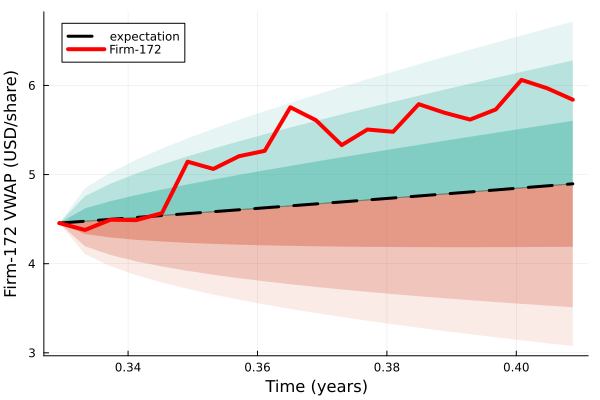

In [16]:
L68 = expectation[:,2] .- sqrt.(variance[:,2])
U68 = expectation[:,2] .+ sqrt.(variance[:,2])
L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

T_range = range(start_index,stop=stop_index-1,step=1) |> collect 
T_sim = T_range*Δt .- Δt

plot(T_sim, expectation[:,2], fillrange=L68, c=colors[5], alpha=0.3, label="")
plot!(T_sim, expectation[:,2], fillrange=U68, c=colors[6], alpha=0.3, label="")
plot!(T_sim, expectation[:,2], fillrange=L95, c=colors[5], alpha=0.2, label="")
plot!(T_sim, expectation[:,2], fillrange=U95, c=colors[6], alpha=0.2, label="")
plot!(T_sim, expectation[:,2], fillrange=L99, c=colors[5], alpha=0.1, label="")
plot!(T_sim, expectation[:,2], fillrange=U99, c=colors[6], alpha=0.1, label="")
plot!(T_sim, expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(T_sim, firm_data[levels .+ start_index, :volume_weighted_average_price],  
    lw=4, c=:red, label="Firm-$(firm_index)", legend = :topleft)

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)", fontsize=18)

The black dashed line is the expected share price predicted by the lattice model, while the shaded regions denote $\mu\pm{z}\cdot\sigma$ for $z=1.0,1.96,2.576$. The solid red line is the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for this firm, and date range.

### Was this a successful simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [15]:
L = L99
U = U99
   
# check the bounds: if below L, or above U then simulation failed
success_flag = true;
for k ∈ 1:T
    if (firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
        success_flag = false;
        break;
    end
end

println("The simultion of the VWAP of Firm-$(firm_index) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")

The simultion of the VWAP of Firm-172 between (84 -> 105) was successful: true
